In [ ]:
### DATA PREPARATION ###
## Importing Necessary Libraries ##
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import time


## Loading Original Dataset ##
raw_df = pd.read_csv('/content/METHANE__PYROLYSIS__DATA .csv')
raw_df.columns = [col.strip() for col in raw_df.columns]

## Defining the Input Variables ##
feature_cols = ['T(C)', 'P(bar)', 'F(mL/h)', 'Y(%)', 'p(W)', 'TOS(h)']

## efining the Feature and Target Columns in the Raw Dataset ##
target_col = 'MoH(g)'

## Defining the Feature and Target Columns in the Raw Dataset ##
X_raw = raw_df[feature_cols].values
y_raw = raw_df[[target_col]].values  # The Shape of the Column (MoE) is (N,1)


## Generating Augmented Data for Training the Neural Networks ##
np.random.seed(42)
N_aug = 100 # The Original Raw Dataset is Multiplied by 100 (X 100)
X_aug = np.repeat(X_raw, N_aug, axis=0)
y_aug = np.repeat(y_raw, N_aug, axis=0)

## Adding of Noise to the Populated Raw Data ##
noise_level = 0.02
X_aug = X_aug * (1 + np.random.randn(*X_aug.shape) * noise_level)
y_aug = y_aug * (1 + np.random.randn(*y_aug.shape) * noise_level)

## Deploying the Logarithm Fucntion to the Target Variable (MoEE) for values MoH < 1 (target = log(MoH + 1)) ##
y_aug_log = np.log1p(y_aug)
y_raw_log = np.log1p(y_raw)

## Deploy a Sanity Check for no NaNs or formation of Negatives ##
print("Sanity check — any NaNs in y_aug_log?", np.isnan(y_aug_log).sum())

## Splitting the Dataset in the ratio of 70:15:15 for the Training, Validation and Test Sets ##

## It is worth noting that the Validation and Testing dataset is still unchanged   ##
X_train_aug, X_val_raw, y_train_log, y_val_log = train_test_split(
    X_aug, y_aug_log, test_size=0.2, random_state=42)

## Final Test Datasets with no Noise ##
X_test_raw = X_raw
y_test_log = y_raw_log

## Standardization of the Argumented Training Dataset ##
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

## Displaying the Shape of the Training, Validation and Testing  ##
print(f"\nTrain shape: {X_train_scaled.shape}, Val shape: {X_val_scaled.shape}, Test shape: {X_test_scaled.shape}")

Sanity check — any NaNs in y_aug_log? 0

Train shape: (1432, 6), Val shape: (358, 6), Test shape: (179, 6)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### PRELIMINARY DATA ANALYSIS OF THE RAW DATASET ###

## Filtering Operating Data with MoH(g) > 0 and NAN from MoH(g) > 0 ##

df_operational = raw_df[(raw_df['MoH(g)'] > 0) & raw_df['SEC(kWh/kg H2)'].notna()].copy()

## Carry Out Descriptive on the Raw Dataset (SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)')  ##

print("### 1. Descriptive Statistics of Derived Variables:\n ###")
desc_stats = df_operational[['SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)']].describe()
print(desc_stats)
print("\n")

## Carry Out Correlation Analysis on the Raw Dataset for both Input and Output dataset:'p(W)', 'B(mT)', 'F(mL/h)', 'X(%)', 'TOS(h)','SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)'  ##
correlation_cols = ['p(W)', 'B(mT)', 'F(mL/h)', 'X(%)', 'TOS(h)', 'SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)']
correlation_matrix = df_operational.dropna(subset=correlation_cols)[correlation_cols].corr(numeric_only=True)
print("### 2. Correlation Matrix of Key Parameters:\n ###")
print(correlation_matrix)
print("\n")

## Carry Out Binned Analysis of SEC by Magnetic Flux (B(mT)) ##
bins = [0, 10, 20, 30, 40, 50, 60]
labels = ['0-10mT', '11-20mT', '21-30mT', '31-40mT', '41-50mT', '51-60mT']
df_operational['B_Bin'] = pd.cut(df_operational['B(mT)'], bins=bins, labels=labels, right=True, include_lowest=True)
binned_sec_analysis = df_operational.groupby('B_Bin')['SEC(kWh/kg H2)'].agg(['mean', 'median', 'min', 'max', 'count'])
print("### 3. Binned Analysis of SEC by Magnetic Flux (B(mT)):\n ###")
print(binned_sec_analysis)
print("\n")


### Identifying the Most Energy-Efficient (Lowest SEC) ROW in the Raw Dataset ###
if not df_operational.empty:
    optimal_row_sec = df_operational.loc[(df_operational['SEC(kWh/kg H2)'].idxmin())]
    print("### 4. Most Energy-Efficient Operating Point (Lowest SEC):\n ###")
    print("The row representing the most energy-efficient operating point (lowest SEC) is:\n")
    print(optimal_row_sec[['p(W)', 'B(mT)', 'F(mL/h)', 'X(%)', 'TOS(h)', 'MoH(g)', 'VoH(L)', 'SEC(kWh/kg H2)', 'EI(MJ/L H2)']].to_markdown(index=True))
else:
    print("No operational data available (no MoH(g) > 0 or SEC is NaN). Cannot identify optimal point.")
print("\n")

### 1. Descriptive Statistics of Derived Variables:
 ###
       SEC(kWh/kg H2)  EI(MJ/L H2)      VoH(L)      MoH(g)
count      179.000000   179.000000  179.000000  179.000000
mean      8000.807484     2.606933   24.771715    2.242073
std      10118.108344     3.296821   58.309660    5.277571
min        658.241180     0.214477    0.063727    0.005768
25%       2462.075181     0.802227    1.212017    0.109699
50%       4628.258294     1.508043    4.923600    0.445632
75%       8995.962787     2.931189   14.407125    1.303980
max      80455.579720    26.215146  419.625000   37.980000


### 2. Correlation Matrix of Key Parameters:
 ###
                    p(W)     B(mT)   F(mL/h)      X(%)    TOS(h)  \
p(W)            1.000000 -0.108309  0.561669 -0.058791  0.483228   
B(mT)          -0.108309  1.000000 -0.181297  0.021182 -0.094980   
F(mL/h)         0.561669 -0.181297  1.000000  0.014420  0.499816   
X(%)           -0.058791  0.021182  0.014420  1.000000 -0.144728   
TOS(h)          0.48

/tmp/ipython-input-2-2753687158.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_sec_analysis = df_operational.groupby('B_Bin')['SEC(kWh/kg H2)'].agg(['mean', 'median', 'min', 'max', 'count'])


In [ ]:
###  FULL MODELLING BLOCK FOR THE FEEDFORWARD NEURAL NETWORK (FNN) ###

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Defining the FNN Model ##
class FNN(nn.Module):
    def __init__(self, input_dim=6, hidden_dims=[256, 128, 64], activation='ReLU'):
        super(FNN, self).__init__()
        act_fn = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh, 'GELU': nn.GELU}[activation]
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]), act_fn(),
            nn.Linear(hidden_dims[0], hidden_dims[1]), act_fn(),
            nn.Linear(hidden_dims[1], hidden_dims[2]), act_fn(),
            nn.Linear(hidden_dims[2], 1)
        )

    def forward(self, x):
        return self.net(x)

## Preparing the Scaled Dataset for training the FNN ##
batch_size = 64
train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                         torch.tensor(y_train_log, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                       torch.tensor(y_val_log, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                        torch.tensor(y_test_log, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Defining the Training Function as well as tracking the losses ##
def train_fnn(model, train_loader, val_loader, n_epochs=1000, lr=1e-3, patience=200):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_model_state = None
    best_val_loss = float('inf')
    wait = 0

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_pred = model(xb).view(-1, 1)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        ## Validating the Trained FNN ##
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                y_pred = model(xb).view(-1, 1)
                epoch_val_loss += criterion(y_pred, yb).item()
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        if epoch % 10 == 0:
            print(f"FNN Epoch {epoch}: Val Loss = {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

## Training the FNN accross all Activation Functions ##
activations = ['ReLU', 'Tanh', 'GELU']
fnn_results = {}
fnn_train_losses = {} # Initialize the dictionary here
fnn_val_losses = {}   # Initialize the dictionary here

for activation in activations:
    print(f"\n FNN({activation})")
    fnn_model = FNN(input_dim=6, hidden_dims=[256, 128, 64], activation=activation)
    start_time = time.time()
    fnn_model, train_losses, val_losses = train_fnn(fnn_model, train_loader, val_loader)
    train_time = time.time() - start_time

    # Store the training and validation losses in the dictionaries
    fnn_train_losses[activation] = train_losses
    fnn_val_losses[activation] = val_losses

    ## Initiate Testing ##
    fnn_model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = fnn_model(xb).view(-1, 1)
            all_preds.append(pred.numpy())
            all_targets.append(yb.numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    y_true = np.expm1(all_targets)
    y_pred = np.expm1(all_preds)

    ## Store Results ##
    fnn_results[activation] = {
        'y_true': y_true,
        'y_pred': y_pred,
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'train_time': train_time,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

    print(f"MAE={fnn_results[activation]['mae']:.4f}, "
          f"MSE={fnn_results[activation]['mse']:.4f}, "
          f"R2={fnn_results[activation]['r2']:.4f}")

    print(f"\nFirst 30 MoH Predictions (FNN - {activation}):")
    for i in range(min(30, len(y_true))):
        print(f"True: {y_true[i,0]:.3f}  Pred: {y_pred[i,0]:.3f}")

    print(f"Training Time: {train_time:.1f} sec")

## Storing the Predictions as well as Raw dataset based on the ReLU Activation Function ##
fnn_preds = fnn_results['ReLU']['y_pred']
y_test_raw = fnn_results['ReLU']['y_true'] # Make sure this is consistent with other cells if needed


 FNN(ReLU)
FNN Epoch 0: Val Loss = 0.0081
FNN Epoch 10: Val Loss = 0.0062
FNN Epoch 20: Val Loss = 0.0029
FNN Epoch 30: Val Loss = 0.0022
FNN Epoch 40: Val Loss = 0.0025
FNN Epoch 50: Val Loss = 0.0025
FNN Epoch 60: Val Loss = 0.0027
FNN Epoch 70: Val Loss = 0.0028
FNN Epoch 80: Val Loss = 0.0017
FNN Epoch 90: Val Loss = 0.0018
FNN Epoch 100: Val Loss = 0.0019
FNN Epoch 110: Val Loss = 0.0018
FNN Epoch 120: Val Loss = 0.0018
FNN Epoch 130: Val Loss = 0.0025
FNN Epoch 140: Val Loss = 0.0023
FNN Epoch 150: Val Loss = 0.0016
FNN Epoch 160: Val Loss = 0.0016
FNN Epoch 170: Val Loss = 0.0018
FNN Epoch 180: Val Loss = 0.0018
FNN Epoch 190: Val Loss = 0.0015
FNN Epoch 200: Val Loss = 0.0022
FNN Epoch 210: Val Loss = 0.0015
FNN Epoch 220: Val Loss = 0.0018
FNN Epoch 230: Val Loss = 0.0016
FNN Epoch 240: Val Loss = 0.0017
FNN Epoch 250: Val Loss = 0.0016
FNN Epoch 260: Val Loss = 0.0016
FNN Epoch 270: Val Loss = 0.0016
FNN Epoch 280: Val Loss = 0.0018
FNN Epoch 290: Val Loss = 0.0015
FNN Epoch

In [ ]:
###  FULL MODELLING BLOCK FOR THE BAYESIAN NEURAL NETWORK (BNN) ###

import torch.nn.functional as F

## Restoring the y_test from the previous test_loader  ##
y_test_log = test_loader.dataset.tensors[1].cpu().numpy()
y_test_raw = np.expm1(y_test_log)

## Defining the BNN Model with Monte Carlo Dropout ##
class BNN(nn.Module):
    def __init__(self, input_dim=6, hidden_dims=[256, 128, 64], dropout=0.1, activation='ReLU'):
        super(BNN, self).__init__()
        act_fn = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh, 'GELU': nn.GELU}[activation]

        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.act1 = act_fn()
        self.do1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.act2 = act_fn()
        self.do2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.act3 = act_fn()
        self.do3 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(hidden_dims[2], 1)

    def forward(self, x):
        x = self.do1(self.act1(self.fc1(x)))
        x = self.do2(self.act2(self.fc2(x)))
        x = self.do3(self.act3(self.fc3(x)))
        x = self.fc4(x)
        return x

## Defining the Training Function as well as tracking the Losses ##
def train_bnn(model, train_loader, val_loader, n_epochs=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_model_state = None
    best_val_loss = float('inf')
    patience = 100
    wait = 0

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_pred = model(xb).squeeze(1)
            yb = yb.squeeze(1)
            loss = F.mse_loss(y_pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                y_pred = model(xb).squeeze(1)
                yb = yb.squeeze(1)
                epoch_val_loss += F.mse_loss(y_pred, yb).item()
        val_losses.append(epoch_val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f"BNN Epoch {epoch}: Val Loss = {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"BNN Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

##  Storing the Results ##
bnn_results = {}
bnn_train_losses = {}
bnn_val_losses = {}

## Running the BNN for all Activation Functions ##
for activation in ['ReLU', 'Tanh', 'GELU']:
    print(f"\n BNN ({activation}) ")
    bnn_model = BNN(activation=activation)

    start_time = time.time()
    bnn_model, train_losses, val_losses = train_bnn(bnn_model, train_loader, val_loader)
    train_time = time.time() - start_time


    ## Saving the Training and Validation losses ##
    bnn_train_losses[activation] = train_losses
    bnn_val_losses[activation] = val_losses

##  Deploying Monte Carlo Dropout Sampling  ##

    bnn_model.train()
    mc_preds = []
    for _ in range(10):
        preds = []
        with torch.no_grad():
            for xb, _ in test_loader:
                pred = bnn_model(xb).cpu().numpy()
                preds.append(pred)
        mc_preds.append(np.vstack(preds))

    mc_preds = np.stack(mc_preds, axis=0)

    ## Performing Inverse Perform  ##
    mean_preds = np.expm1(mc_preds.mean(axis=0))
    std_preds = np.expm1(mc_preds.std(axis=0))

    ## Computing the Error Metrics ##
    mae = mean_absolute_error(y_test_raw, mean_preds)
    mse = mean_squared_error(y_test_raw, mean_preds)
    r2 = r2_score(y_test_raw, mean_preds)

    bnn_results[activation] = {
        'y_pred': mean_preds,
        'y_std': std_preds,
        'y_true': y_test_raw,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'train_time': train_time
    }

    print(f"BNN({activation}): MAE={mae:.4f}, MSE={mse:.4f}, R2={r2:.4f}")

    print(f"\nFirst 30 MoH Predictions (BNN - {activation}):")
    for i in range(min(30, len(y_test_raw))):
        print(f"True: {y_test_raw[i,0]:.3f}  Pred: {mean_preds[i,0]:.3f} ± {std_preds[i,0]:.3f}")

    print(f"Training Time: {train_time:.1f} sec")

## Extracting the Predictions based on the GeLU Activation Function ##
bnn_preds = bnn_results['GELU']['y_pred']
bnn_std = bnn_results['GELU']['y_std']


 BNN (ReLU) 
BNN Epoch 0: Val Loss = 0.6697
BNN Epoch 10: Val Loss = 0.3614
BNN Epoch 20: Val Loss = 0.1596
BNN Epoch 30: Val Loss = 0.4146
BNN Epoch 40: Val Loss = 0.3151
BNN Epoch 50: Val Loss = 0.1617
BNN Epoch 60: Val Loss = 0.1431
BNN Epoch 70: Val Loss = 0.1060
BNN Epoch 80: Val Loss = 0.0980
BNN Epoch 90: Val Loss = 0.1924
BNN Epoch 100: Val Loss = 0.1160
BNN Epoch 110: Val Loss = 0.0989
BNN Epoch 120: Val Loss = 0.1432
BNN Epoch 130: Val Loss = 0.1657
BNN Epoch 140: Val Loss = 0.1041
BNN Epoch 150: Val Loss = 0.1396
BNN Epoch 160: Val Loss = 0.0936
BNN Epoch 170: Val Loss = 0.1135
BNN Epoch 180: Val Loss = 0.1319
BNN Epoch 190: Val Loss = 0.1287
BNN Epoch 200: Val Loss = 0.0886
BNN Epoch 210: Val Loss = 0.1502
BNN Epoch 220: Val Loss = 0.1066
BNN Epoch 230: Val Loss = 0.1085
BNN Epoch 240: Val Loss = 0.1212
BNN Epoch 250: Val Loss = 0.1036
BNN Epoch 260: Val Loss = 0.0973
BNN Epoch 270: Val Loss = 0.0839
BNN Epoch 280: Val Loss = 0.1247
BNN Epoch 290: Val Loss = 0.2068
BNN Epo

In [ ]:
### FULL MODELLING BLOCK FOR THE HYBRID BAYESIAN NEURAL NETWORK (HYBRID-BNN) ###

import torch.nn.functional as F

## Defining the Input Dimension ##

input_dim = X_train_scaled.shape[1]

## Defining the Hybrid-BNN Model ##
class HybridBNN(nn.Module):
    def __init__(self, input_dim, activation='ReLU', p_dropout=0.1):
        super(HybridBNN, self).__init__()
        act_fn = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh, 'GELU': nn.GELU}[activation]

        self.dropout = nn.Dropout(p_dropout)
        self.activation = act_fn()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

## Defining the Training Function as well as tracking the losses ##

def train_hybrid_bnn(model, train_loader, val_loader, n_epochs=500, lr=1e-3, patience=50):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    wait = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_pred = model(xb).squeeze()
            loss = criterion(y_pred, yb.squeeze())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                y_pred = model(xb).squeeze()
                epoch_val_loss += criterion(y_pred, yb.squeeze()).item()
        val_losses.append(epoch_val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f"HybridBNN Epoch {epoch}: Val Loss = {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"HybridBNN Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

## Defining the Monte Carlo Dropout function ##

def mc_predict(model, test_loader, mc_iterations=100):
    model.train()
    mc_preds = []
    for _ in range(mc_iterations):
        preds = []
        with torch.no_grad():
            for xb, _ in test_loader:
                pred = model(xb).cpu().numpy().reshape(-1, 1)
                preds.append(pred)
        preds = np.vstack(preds)
        ## Perfoming Inversse Logarithm Tranform (log1p) due to the nature of the recorded Mass of Hydrogen (MoH) ##
        preds = np.expm1(preds)
        mc_preds.append(preds.squeeze())
    return np.stack(mc_preds)

## EPreparing the DataLoaders for the Scaled Dataset ##
batch_size = 64

train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                         torch.tensor(y_train_log, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                       torch.tensor(y_val_log, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                        torch.tensor(y_test_log, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Computing the Ground Truth ##
y_test_log = y_test_log.reshape(-1, 1)
y_test_raw = np.expm1(y_test_log)

## Training the HybridBNN accross alln Activation Functions (ReLU, Tanh and, GeLU) ##

hybrid_results = {}
hybrid_train_losses = {}
hybrid_val_losses = {}

for activation in ['ReLU', 'Tanh', 'GELU']:
    print(f"\n HybridBNN ({activation}) ")
    model = HybridBNN(input_dim=input_dim, activation=activation, p_dropout=0.1)

    start_time = time.time()
    model, train_losses, val_losses = train_hybrid_bnn(model, train_loader, val_loader)
    train_time = time.time() - start_time

    ## Saving the losses for both Validation and Training ##

    hybrid_train_losses[activation] = train_losses
    hybrid_val_losses[activation] = val_losses

    ## Monte Carlo (MC) Predictions ##
    mc_preds = mc_predict(model, test_loader, mc_iterations=100)
    mean_preds = mc_preds.mean(axis=0).reshape(-1, 1)
    std_preds = mc_preds.std(axis=0).reshape(-1, 1)

    ## Computing the Error Metrics ##
    mae = mean_absolute_error(y_test_raw, mean_preds)
    mse = mean_squared_error(y_test_raw, mean_preds)
    r2 = r2_score(y_test_raw, mean_preds)

    ## Storing the Results ##
    hybrid_results[activation] = {
        'y_true': y_test_raw,
        'y_pred': mean_preds,
        'y_std': std_preds,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'train_time': train_time
    }

    print(f"HybridBNN ({activation}): MAE={mae:.4f}, MSE={mse:.4f}, R²={r2:.4f}")
    print(f"\nFirst 30 MoH Predictions (HybridBNN - {activation}):")
    for i in range(min(30, len(y_test_raw))):
        print(f"True: {y_test_raw[i,0]:.3f}  Pred: {mean_preds[i,0]:.3f} ± {std_preds[i,0]:.3f}")

    print(f"Training Time: {train_time:.1f} sec")

## Extracting the Predictions based on the GeLU Activation Function ##
hybrid_preds = hybrid_results['GELU']['y_pred']
hybrid_std = hybrid_results['GELU']['y_std']


 HybridBNN (ReLU) 
HybridBNN Epoch 0: Val Loss = 0.8995
HybridBNN Epoch 10: Val Loss = 0.1660
HybridBNN Epoch 20: Val Loss = 0.3113
HybridBNN Epoch 30: Val Loss = 0.1266
HybridBNN Epoch 40: Val Loss = 0.1677
HybridBNN Epoch 50: Val Loss = 0.1376
HybridBNN Epoch 60: Val Loss = 0.1991
HybridBNN Epoch 70: Val Loss = 0.1166
HybridBNN Epoch 80: Val Loss = 0.1138
HybridBNN Epoch 90: Val Loss = 0.1057
HybridBNN Epoch 100: Val Loss = 0.1028
HybridBNN Epoch 110: Val Loss = 0.1236
HybridBNN Epoch 120: Val Loss = 0.2006
HybridBNN Epoch 130: Val Loss = 0.1593
HybridBNN Epoch 140: Val Loss = 0.1954
HybridBNN Epoch 150: Val Loss = 0.1003
HybridBNN Epoch 160: Val Loss = 0.1071
HybridBNN Early stopping at epoch 163
HybridBNN (ReLU): MAE=0.1828, MSE=0.7208, R²=0.9740

First 30 MoH Predictions (HybridBNN - ReLU):
True: 0.101  Pred: 0.123 ± 0.041
True: 0.127  Pred: 0.131 ± 0.047
True: 0.380  Pred: 0.367 ± 0.044
True: 0.620  Pred: 0.593 ± 0.042
True: 0.851  Pred: 0.859 ± 0.048
True: 0.934  Pred: 0.917 ± 

In [ ]:
### Volume of Hydrogen (VoH) Predictions via MoH → VoH Mathematical Relationship ###

## Computing the Actual Volume of Hydrogen (VoH) based on the relation (MoH → VoH : VoH = 11.11*MoH ##
y_test_voh = 11.11 * y_test_raw

## Computing the VoH predictions accross all activation functions ##
moh_pred_fnn_relu=fnn_results['ReLU']['y_pred']
moh_pred_bnn_gelu=bnn_results['GELU']['y_pred']
moh_pred_hybrid_gelu=hybrid_results['GELU']['y_pred']
voh_pred_fnn_relu = 11.11 * moh_pred_fnn_relu
voh_pred_bnn_gelu = 11.11 * moh_pred_bnn_gelu
voh_pred_hybrid_gelu = 11.11 * moh_pred_hybrid_gelu

## Defining the Error Metrics Function ##
def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"\n{label}: MAE={mae:.4f}, MSE={mse:.4f}, R2={r2:.4f}")

## Computing the predictions for the FNN, BNN and Hybrid-BNN  ##
print_metrics(y_test_voh, voh_pred_fnn_relu, "FNN (RELU) MoH → VoH")
print_metrics(y_test_voh, voh_pred_bnn_gelu, "BNN (GELU) MoH → VoH")
print_metrics(y_test_voh, voh_pred_hybrid_gelu, "Hybrid-BNN (GELU) MoH → VoH")

## Computing the first 30 predictions for the FNN, BNN and Hybrid-BNN with the best activation functions. ##
df_results = pd.DataFrame({
    'True VoH': y_test_voh.flatten(),
    'Pred FNN': voh_pred_fnn_relu.flatten(),
    'Pred BNN': voh_pred_bnn_gelu.flatten(),
    'Pred HybridBNN': voh_pred_hybrid_gelu.flatten()
})

print("\n First 30 VoH Predictions via MoH → VoH Relation \n")
print(df_results.head(30).to_string(index=False))


FNN (RELU) MoH → VoH: MAE=1.3605, MSE=43.1063, R2=0.9874

BNN (GELU) MoH → VoH: MAE=2.0168, MSE=90.6192, R2=0.9735

Hybrid-BNN (GELU) MoH → VoH: MAE=2.1681, MSE=111.1317, R2=0.9675

 First 30 VoH Predictions via MoH → VoH Relation 

  True VoH   Pred FNN   Pred BNN  Pred HybridBNN
  1.125221   1.108135   0.825024        0.927024
  1.406526   1.352823   1.252415        1.214808
  4.219578   4.103921   4.057487        3.545249
  6.891977   6.865780   7.072646        6.191770
  9.451855   9.433436   9.515311        7.965971
 10.380161  10.317077  10.598945        9.484961
 15.471785  15.329061  15.671353       14.050975
 17.018963  17.088926  17.527809       16.064762
 33.756626  33.498421  34.335114       32.779995
 32.912708  32.317875  33.556023       32.299732
 31.506184  31.102158  33.219215       30.768883
 30.380964  29.955307  31.397720       29.014097
 23.442099  23.489256  23.340969       24.905792
 51.572617  50.458046  51.133274       53.662102
 84.391571  82.486031  79.64740

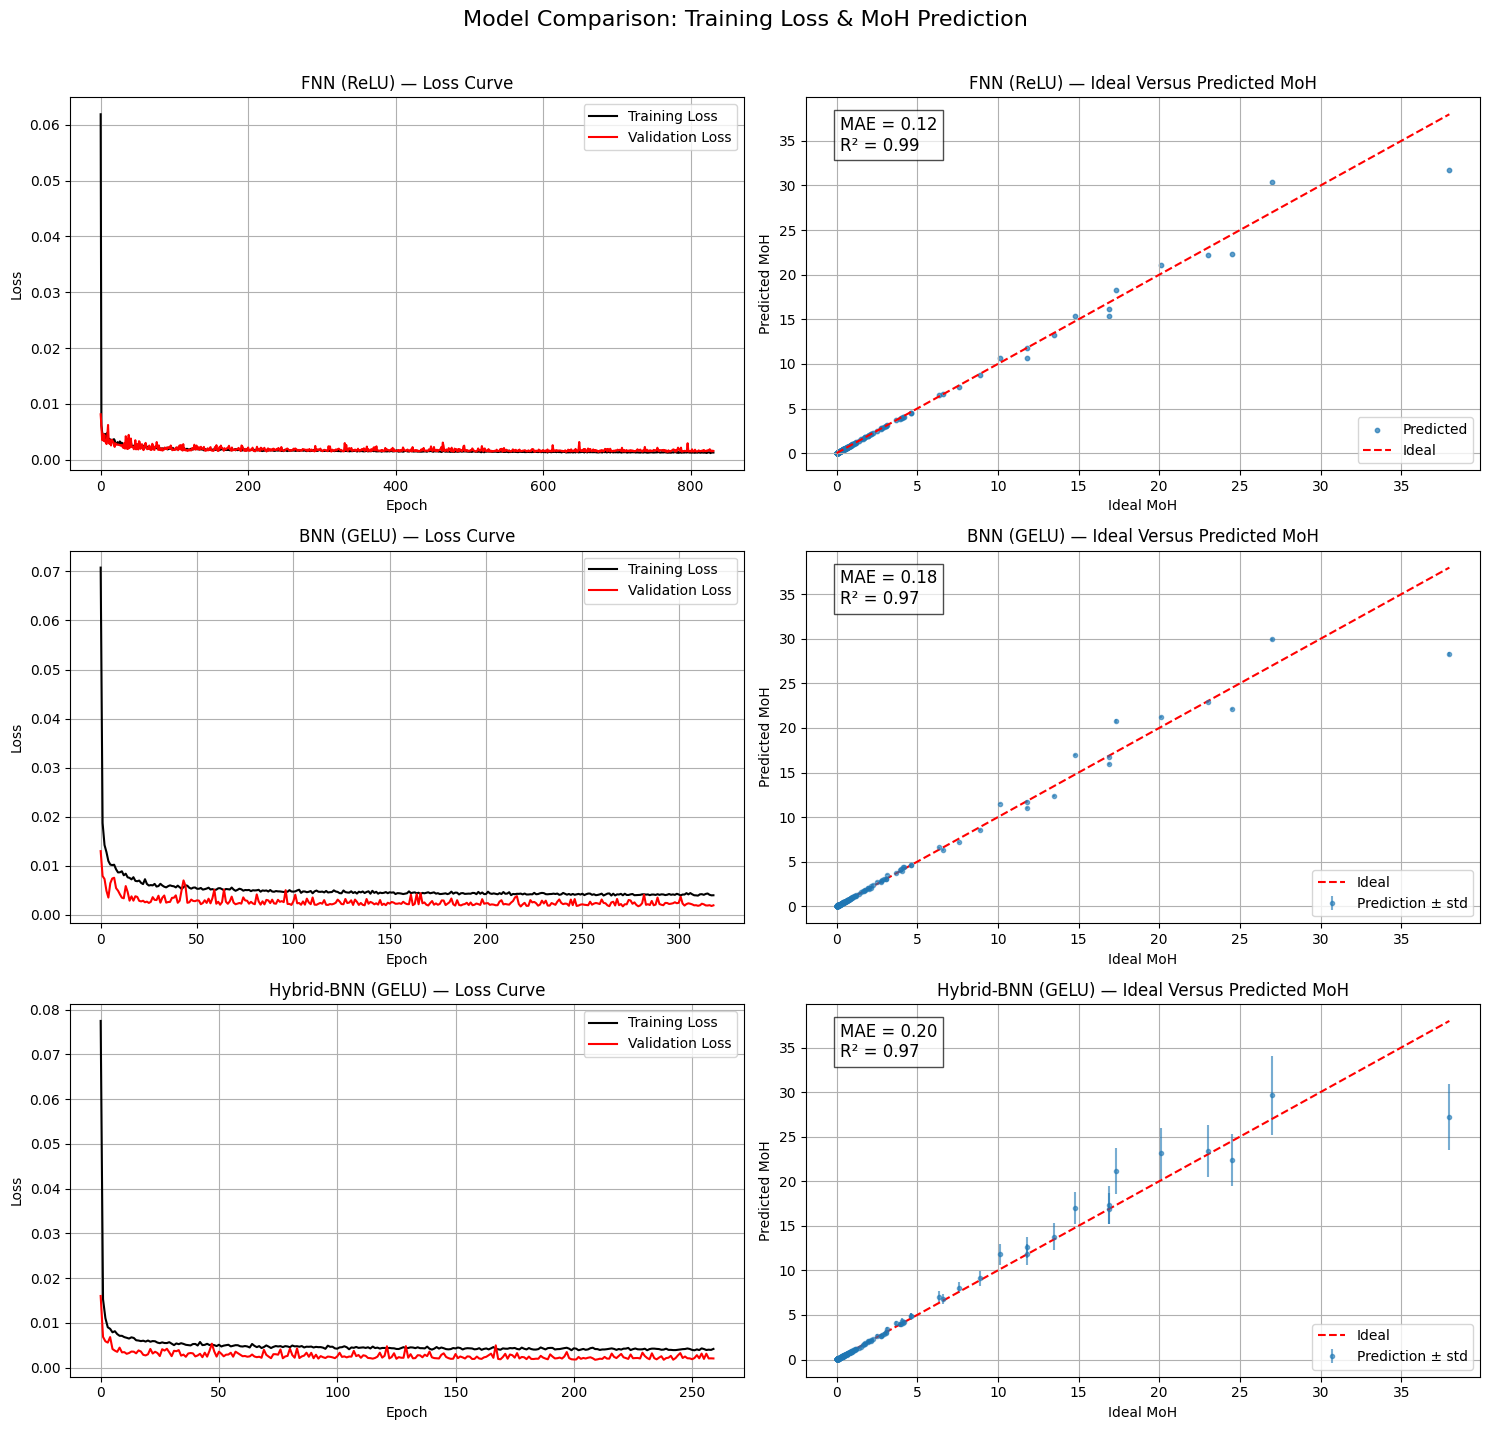

In [ ]:
### GRAPHICAL PLOTS FOR IDEAL VERSUS PREDICTED VALUES & TRAINING AND VALIDATION LOSS TRACKING (COMBINED) ###

## Defining the selected Neural Network Model and their corresponding Activation Functions ##
models = ['FNN', 'BNN', 'Hybrid-BNN']
activations = {'FNN': 'ReLU', 'BNN': 'GELU', 'Hybrid-BNN': 'GELU'}

## Defining the selected neural network model training & validation losses dictionaries as well as their corresponding activation functions ##
train_losses_dict = {
    'FNN': fnn_train_losses,
    'BNN': bnn_train_losses,
    'Hybrid-BNN': hybrid_train_losses
}

val_losses_dict = {
    'FNN': fnn_val_losses,
    'BNN': bnn_val_losses,
    'Hybrid-BNN': hybrid_val_losses
}

results_dict = {
    'FNN': fnn_results,
    'BNN': bnn_results,
    'Hybrid-BNN': hybrid_results
}


## Defining the Graphical Plot Configurations ##
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle("Model Comparison: Training Loss & MoH Prediction", fontsize=16)

for idx, model in enumerate(models):
    act = activations[model]


    ## Graphical Plots 1: Training vs Validation Loss ##
    ax1 = axes[idx, 0]
    ax1.plot(train_losses_dict[model][act], label='Training Loss',color='k')
    ax1.plot(val_losses_dict[model][act], label='Validation Loss',color='r')
    ax1.set_title(f'{model} ({act}) — Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ## Graphical Plots 2: True vs Predicted MoH ##
    ax2 = axes[idx, 1]
    y_true = results_dict[model][act]['y_true']
    y_pred = results_dict[model][act]['y_pred']

    ## Adding Errors Bars for uncertainty for theHybrid-BNN ##

    if 'y_std' in results_dict[model][act]:
        y_std = results_dict[model][act]['y_std']
        ax2.errorbar(y_true.flatten(), y_pred.flatten(), yerr=y_std.flatten(), fmt='o', markersize=3, alpha=0.6, label='Prediction ± std')
    else:
        ax2.scatter(y_true, y_pred, s=10, alpha=0.7, label='Predicted')

    ## Diagonal line for the Ideal versus Predicted MoH Graphical Plots ##

    ax2.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')

    ## Annotating the Metrics on the MoH Graphical Plots ##
    mae = results_dict[model][act]['mae']
    r2 = results_dict[model][act]['r2']
    ax2.text(0.05, 0.95, f'MAE = {mae:.2f}\nR² = {r2:.2f}', transform=ax2.transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    ax2.set_title(f'{model} ({act}) — Ideal Versus Predicted MoH')
    ax2.set_xlabel('Ideal MoH')
    ax2.set_ylabel('Predicted MoH')
    ax2.legend()
    ax2.grid(True)

## Final Layout Adjustments for the Graphical Plots ##
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("Model_Comparison_Plots.png", dpi=600)
plt.show()

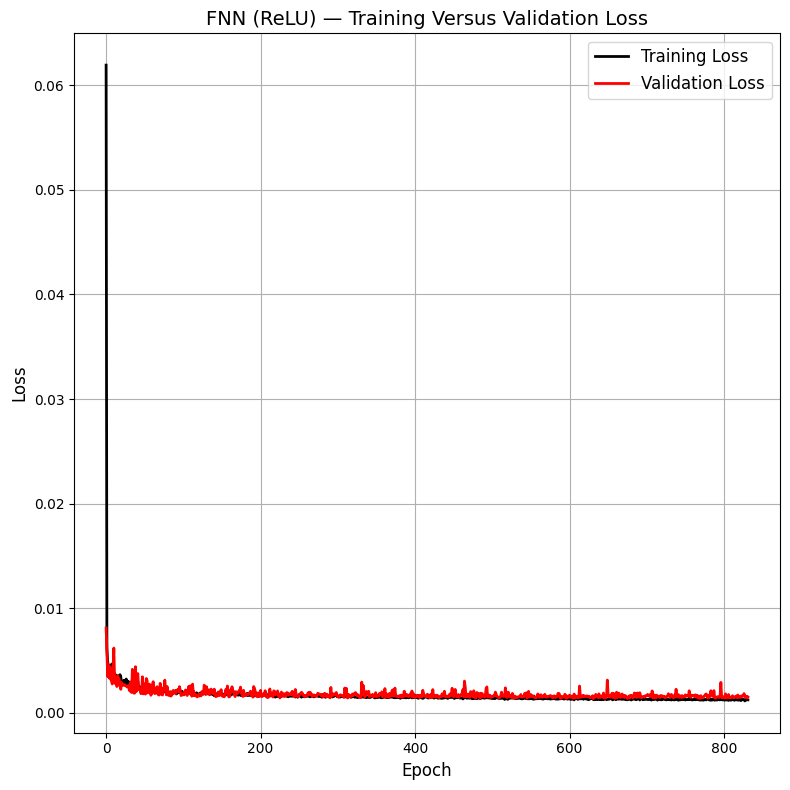

Saved: Individual_Model_Plots/fnn_Loss_Plot.png


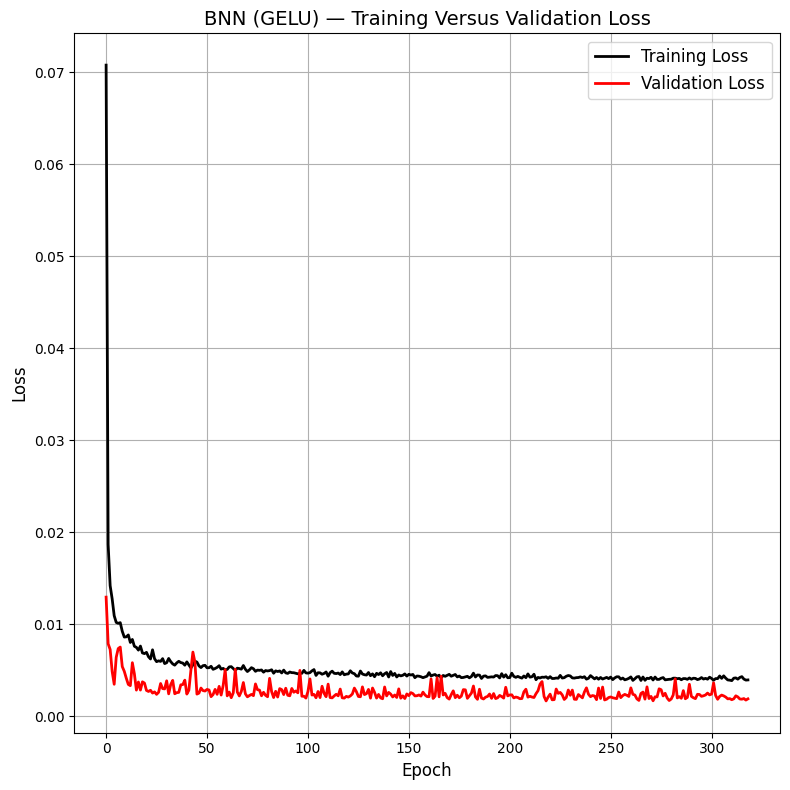

Saved: Individual_Model_Plots/bnn_Loss_Plot.png


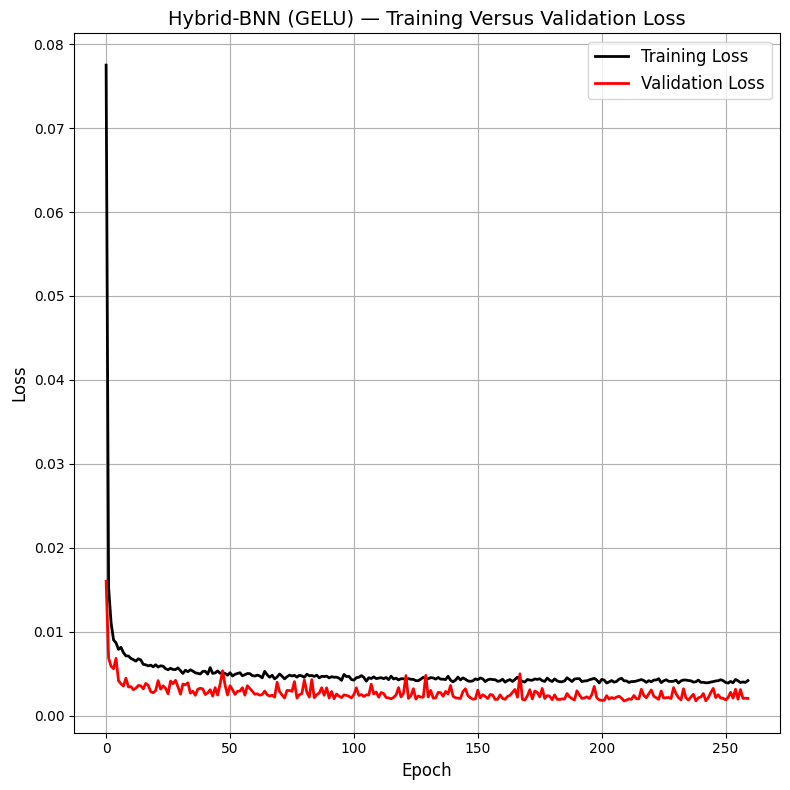

Saved: Individual_Model_Plots/hybrid_bnn_Loss_Plot.png


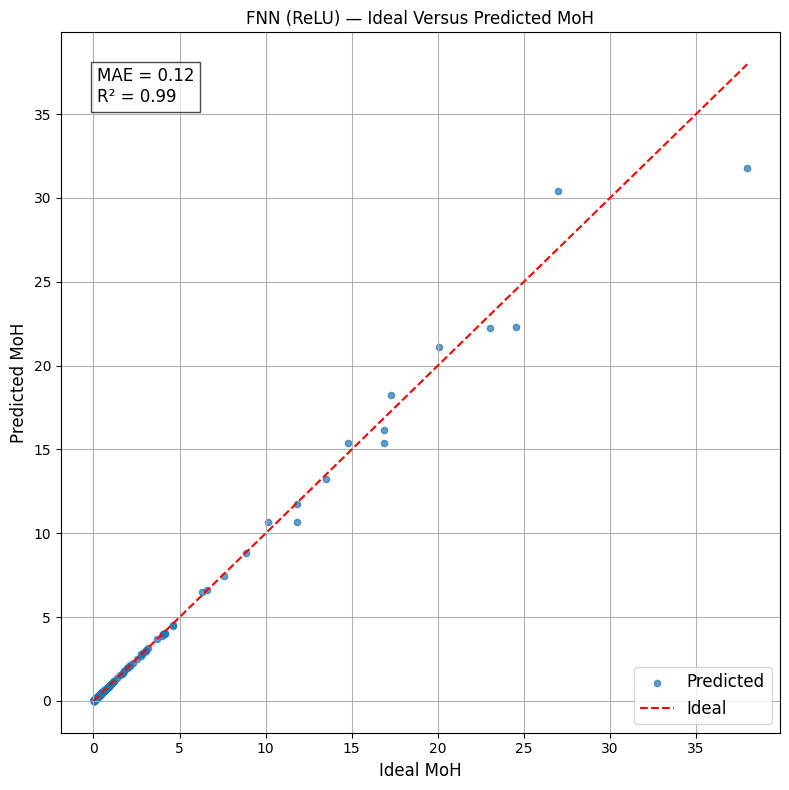

Saved: Individual_Model_Plots/fnn_Prediction_Plot.png


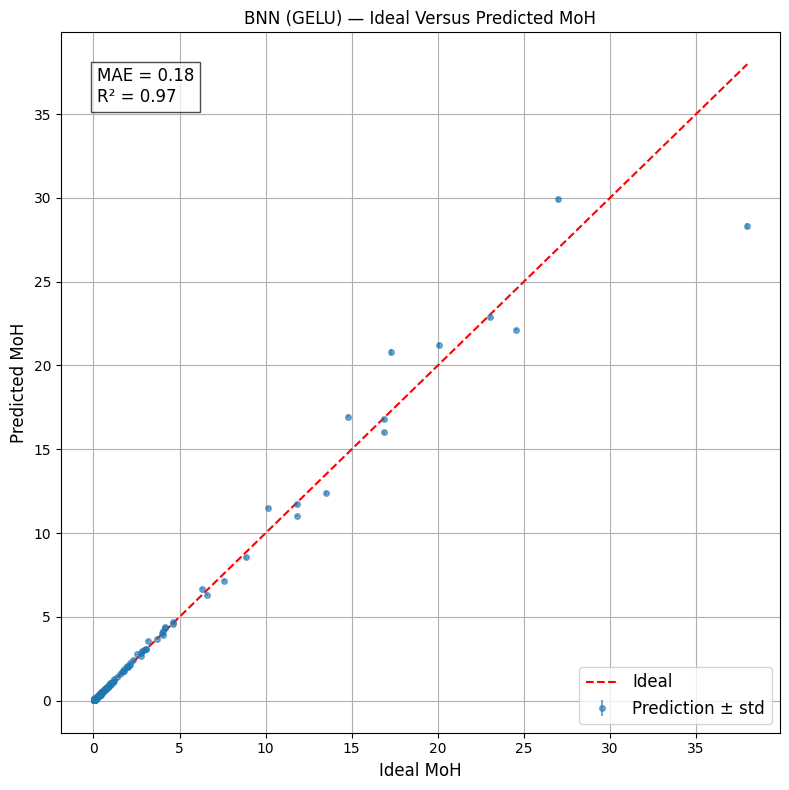

Saved: Individual_Model_Plots/bnn_Prediction_Plot.png


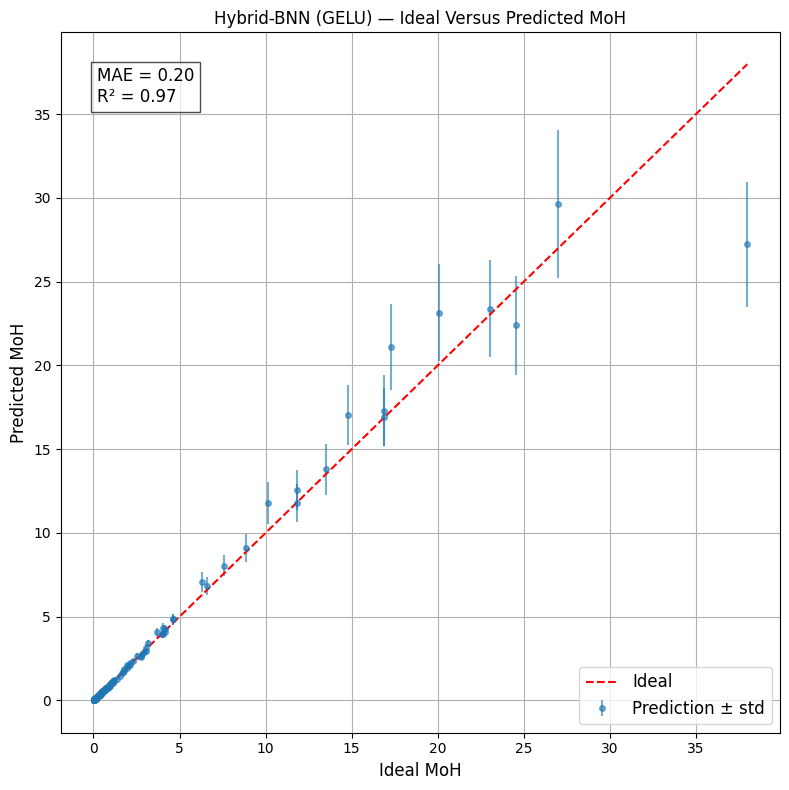

Saved: Individual_Model_Plots/hybrid_bnn_Prediction_Plot.png


In [ ]:
### GRAPHICAL PLOTS FOR IDEAL VERSUS PREDICTED VALUES & TRAINING AND VALIDATION LOSS TRACKING (INDIVIDUAL) ###

## Creating a Directory doe Saving the Graphical Plots ##
os.makedirs("Individual_Model_Plots", exist_ok=True)

## Defining the Models and Activation Mappings  ##
models = ['FNN', 'BNN', 'Hybrid-BNN']
activations = {'FNN': 'ReLU', 'BNN': 'GELU', 'Hybrid-BNN': 'GELU'}


## Defining the Training and Validation Loss Plots  ##
for model in models:
    act = activations[model]

    plt.figure(figsize=(8, 8))
    plt.plot(train_losses_dict[model][act], label="Training Loss", linewidth=2, color='k')
    plt.plot(val_losses_dict[model][act], label="Validation Loss", linewidth=2, color='r')
    plt.title(f"{model} ({act}) — Training Versus Validation Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    filename = f"Individual_Model_Plots/{model.lower().replace('-', '_')}_Loss_Plot.png"
    plt.savefig(filename, dpi=600)
    plt.show()
    print(f"Saved: {filename}")

## Defining the Graphical Plots for each model:True Versus Predicted MoH Plots  ##
for model in models:
    act = activations[model]
    y_true = results_dict[model][act]["y_true"]
    y_pred = results_dict[model][act]["y_pred"]

    plt.figure(figsize=(8, 8))

    if "y_std" in results_dict[model][act]:
        y_std = results_dict[model][act]["y_std"]
        plt.errorbar(y_true.flatten(), y_pred.flatten(), yerr=y_std.flatten(),
                     fmt='o', markersize=4, alpha=0.6, label="Prediction ± std")
    else:
        plt.scatter(y_true, y_pred, s=20, alpha=0.7, label="Predicted")

     ## Plotting the Reference Line ##
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
             'r--', label="Ideal")

    ## Annotating the Metrics ##
    mae = results_dict[model][act]["mae"]
    r2 = results_dict[model][act]["r2"]
    plt.text(0.05, 0.95, f"MAE = {mae:.2f}\nR² = {r2:.2f}", transform=plt.gca().transAxes,
             fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

    plt.title(f"{model} ({act}) — Ideal Versus Predicted MoH", fontsize=12)
    plt.xlabel("Ideal MoH", fontsize=12)
    plt.ylabel("Predicted MoH", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    filename = f"Individual_Model_Plots/{model.lower().replace('-', '_')}_Prediction_Plot.png"
    plt.savefig(filename, dpi=600)
    plt.show()
    print(f"Saved: {filename}")

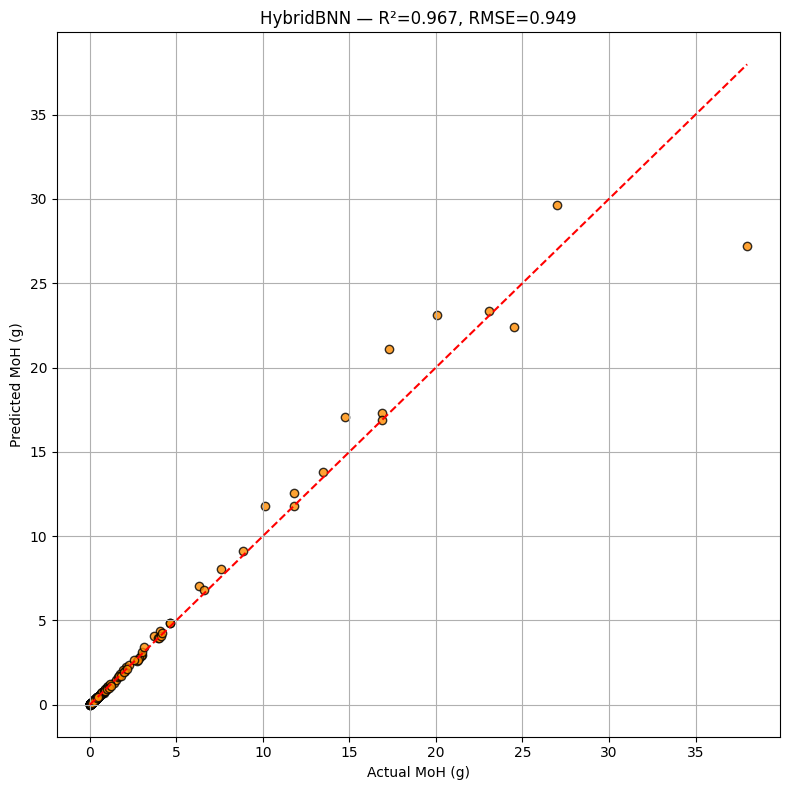

In [ ]:
### INDIVIDUAL GRAPHICAL PLOTS ###
y_true = y_test_raw.flatten()
y_pred_fnn = fnn_results['ReLU']['y_pred'].flatten()
y_pred_bnn = bnn_results['GELU']['y_pred'].flatten()
y_pred_hybrid = hybrid_results['GELU']['y_pred'].flatten()

## Defining Plotting Function with the metrics ##
def plot_pred_vs_true(y_true, y_pred, model_name, color='blue'):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    plt.figure(figsize=(8,8))
    plt.scatter(y_true, y_pred, color=color, alpha=0.8, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual MoH (g)')
    plt.ylabel('Predicted MoH (g)')
    plt.title(f'{model_name} — R²={r2:.3f}, RMSE={rmse:.3f}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('HYBRID_BNN_PLOT_MOH', dpi=600)
    plt.show()
## Graphical Plots for Each Model ##
# plot_pred_vs_true(y_true, y_pred_fnn, "FNN", color='dodgerblue')
# plot_pred_vs_true(y_true, y_pred_bnn, "BNN", color='seagreen')
# plot_pred_vs_true(y_true, y_pred_hybrid, "HybridBNN", color='darkorange')

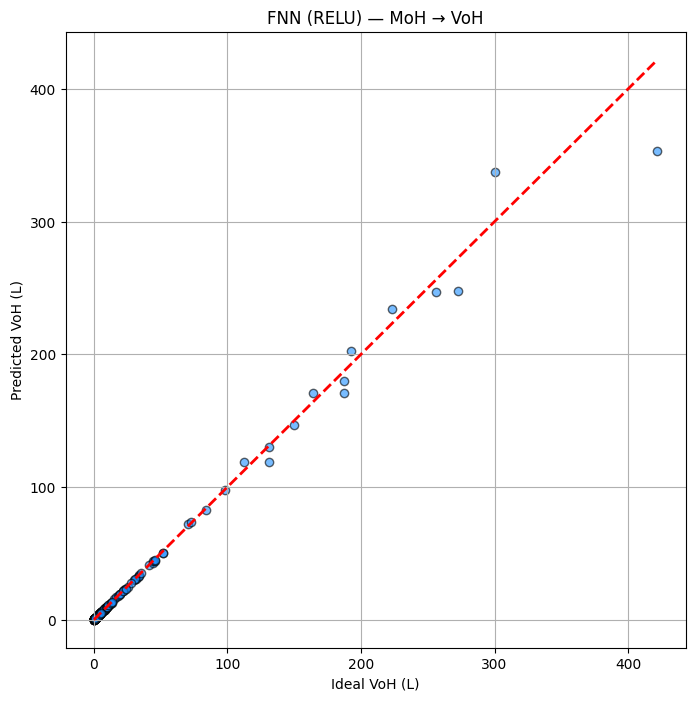

In [ ]:
## Defining the Function for the Ideal Versus True VoH ##
def plot_voh_predictions(y_true, y_pred, title, color='blue'):
    plt.figure(figsize=(8,8))
    plt.scatter(y_true, y_pred, color=color, alpha=0.6, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Ideal VoH (L)")
    plt.ylabel("Predicted VoH (L)")
    plt.title(title)
    plt.grid(True)
    plt.savefig('FNN_PLOT_VOH', dpi=600)
    plt.show()

## Graphical Plots for each model in additon to their best configurations: Ideal Versus True VoH ##
# plot_voh_predictions(y_test_voh, voh_pred_fnn_relu, "FNN (RELU) — MoH → VoH", color='dodgerblue')
# plot_voh_predictions(y_test_voh, voh_pred_bnn_gelu, "BNN(GELU) — MoH → VoH", color='seagreen')
# plot_voh_predictions(y_test_voh, voh_pred_hybrid_gelu, "HybridBNN (GELU) — MoH → VoH", color='darkorange')